# Reinforcement Learing - Case 1

### Packages for RF

In [3]:
import keras
from keras import layers,models,optimizers 
from keras import backend as K
from collections import namedtuple,deque
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizer_v2.adam import Adam

### Packages for data processing / visualization

In [27]:
import numpy as np
import pandas as pd
from pandas import set_option
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from numpy.random import choice
import random

### Load data from URL on Hariom's Github

In [9]:
url = 'https://raw.githubusercontent.com/tatsath/fin-ml/master/Chapter%209%20-%20Reinforcement%20Learning/Case%20Study%201%20-%20Reinforcement%20Learning%20based%20Trading%20Strategy/data/SP500.csv'
dataset = pd.read_csv(url,index_col=0)
dataset.shape

(2516, 6)

In [13]:
set_option('display.width', 100)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


<AxesSubplot:xlabel='Date', ylabel='Close'>

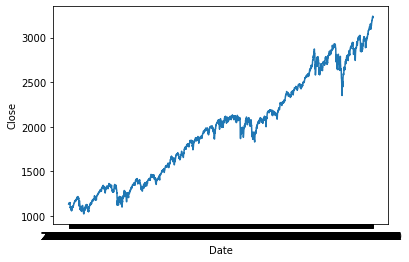

In [16]:
sns.lineplot(
    data=dataset, x='Date', y='Close'
)

### Check for nulls

In [17]:
print('Null Values =',dataset.isnull().values.any())

Null Values = False


### Train/Test Split

In [19]:
X = list(dataset['Close'])
X = [float(x) for x in X]
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size],X[train_size:len(X)]

### Create Agent Class

In [32]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=''):
        self.state_size = state_size
        self.action_size = 3 #buy, sell, or hold
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        # load model in model_name for testing if isEval = True, otherwise use model created below
        self.model = load_model('models/' + model_name) if is_eval else self._model()
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(units=32, activation='relu'))
        model.add(Dense(units=8, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=0.001))

        return model

    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        
        options = self.model.predict(state)
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        # Prepare replay memory
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        # Iterate across memory batch
        for state, action, reward, next_state, done in mini_batch:
            target = reward # Q at time t 
            # Upate target for Q table
            if not done:
                target = reward + self.gamma * \
                    np.amax(self.model.predict(next_state)[0])

            # Q-value of state from table
            target_f = self.model.predict(state)
            # Update the output Q table for the given action
            target_f[0][action] = target
            # Train and fit the model
            self.model.fit(state, target_f, epochs=1, verbose=0)

        # Implement epsilon greedy algorithm
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

### Helper Functions

In [36]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def formatPrice(n):
    return (
        ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))
    )

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n-1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15, 5))
    plt.plot(data_input, color='r', lw=2)
    plt.plot(
        data_input, '^', markersize=10, color='m', 
        label = 'Buying Signal', markevery=states_buy
        )
    plt.plot(
        data_input, 'v', markersize=10, color='k',
        label='Selling Signal', markevery=states_sell
    )
    plt.title('Total Gains: %f' % profit)
    plt.legend()
    plt.show()

### Training Model

Episode 0/3
---------
Total Profit: $955.29
---------


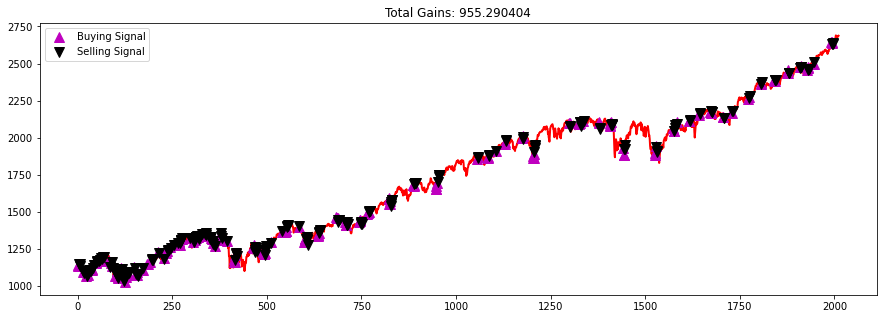

INFO:tensorflow:Assets written to: models/models_ep0\assets
Episode 1/3
---------
Total Profit: -$636.55
---------


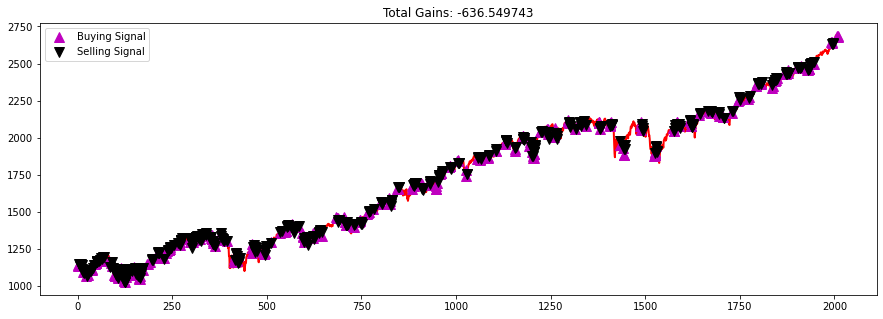

Episode 2/3
---------
Total Profit: $377.60
---------


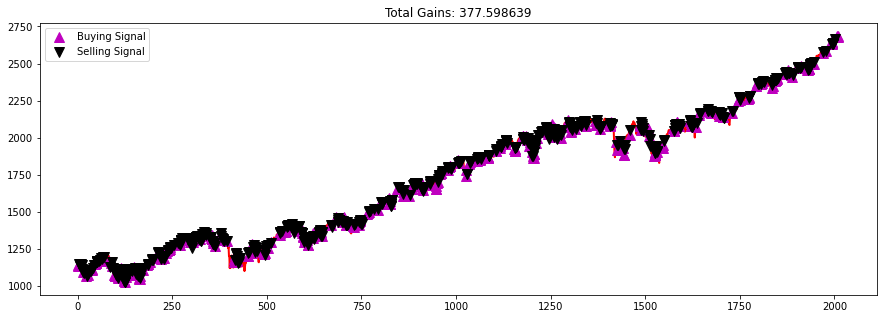

Episode 3/3
---------
Total Profit: -$289.22
---------


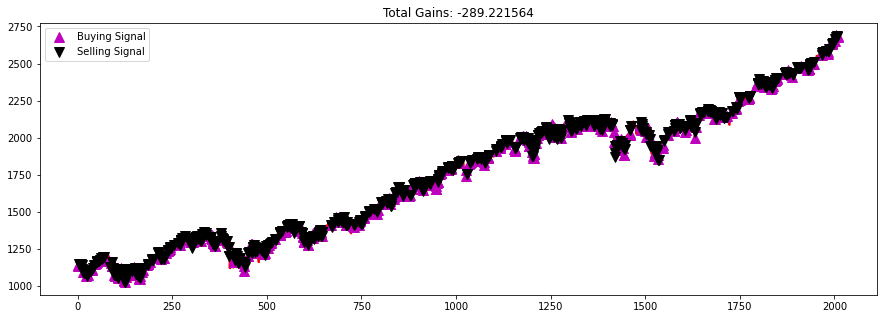

In [43]:
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data) -1
batch_size = 10
states_sell = []
states_buy = []
episode_count = 3

for e in range(episode_count + 1):
    print('Episode ' + str(e) + '/' + str(episode_count))
    # get state
    state = getState(data, 0, window_size + 1)

    total_profit = 0
    agent.inventory = []

    for t in range(l):
        # take best action
        action = agent.act(state)
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            # print('Buy: ' + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            # get reward

            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            # print('Sell: ' + formatPrice(data[t]) + '\nProfit: ' \
            #    + formatPrice(data[t] - bought_price))
        
        done = True if t == l - 1 else False
        # get next state
        next_state = getState(data, t + 1, window_size + 1)
        # add to memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('---------')
            print('Total Profit: ' + formatPrice(total_profit))
            print('---------')

            plot_behavior(
                data,states_buy,states_sell,total_profit
            )

        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

    if e % 10 == 0:
        agent.model.save('models/models_ep' + str(e))            


In [44]:
print(agent.model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 64)                128       
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 8)                 264       
                                                                 
 dense_39 (Dense)            (None, 3)                 27        
                                                                 
Total params: 2,499
Trainable params: 2,499
Non-trainable params: 0
_________________________________________________________________
None


### Testing

In [48]:
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
model_name = 'models_ep3'
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size+1)
total_profit = 0
agent.inventory = []

for t in range(l_test):
    action = agent.act(state)

    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        # print('Buy: ' + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += test_data[t] - bought_price
        # print('Sell: ' + formatPrice(test_data[t]) + ' | Profit:' + formatPrice(test_data[t] - bought_price))
    
    if t == l_test - 1:
        done = True
    
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('---------')
        print('Total Profit: ' + formatPrice(total_profit))
        print('---------')
plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)

OSError: No file or directory found at models/models_ep3